#### Active learning NNGP experiment
We use one set of params for simple example

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

from model.mlp import MLP
from dataloader.rosen import RosenData
from uncertainty_estimator.nngp import NNGP
from sample_selector.eager import EagerSampleSelector
from oracle.identity import IdentityOracle


In [4]:
config = {
    'random_state': 4623457,
    'n_dim': 10,
    'n_train': 200,
    'n_test': 200,
    'n_pool': 1000,
    'layers': [128, 64, 32],
    'update_sample_size': 10,
    'al_iterations': 10
}

np.random.seed(config['random_state'])

In [5]:
def print_shapes(note, *sets):
    print(note)
    for x, y in sets:
        print("shapes:", x.shape, y.shape)

# load data
X_train, y_train, _, _, X_test, y_test, X_pool, y_pool = RosenData(
    config['n_train'], 0, config['n_test'], config['n_pool'], config['n_dim']
).dataset()

In [6]:
# Init neural network & tf session
tf.reset_default_graph()

model = MLP(
    ndim = config['n_dim'],
    random_state = config['random_state'],
    layers = config['layers']
)

try:
    sess.close()
except:
    pass
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

init = tf.global_variables_initializer()
sess = tf.Session(config=session_config)
sess.run(init)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [17]:
estimator = NNGP(model)  # to estimate uncertainties
# oracle = IdentityOracle(y_pool)  # generate y for X from pool
# sampler = EagerSampleSelector(oracle) # sample X and y from pool by uncertainty estimations

estimator.estimate(sess, X_train, y_train, X_pool)[:50]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]
[[-0.1989958  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.       ]]
[[-0.1989958  -0.23381726  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]]
[[-0.1989958  -0.23381726 -0.12259002  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]]
[[-0.1989958  -0.23381726 -0.12259002 -0.19776772  0.          0.
   0.          0.          0.     

array([0.        , 0.        , 0.        , 0.        , 0.00796935,
       0.01148678, 0.02160214, 0.        , 0.02019272, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01151447, 0.01062656, 0.        , 0.        , 0.00962229,
       0.        , 0.        , 0.        , 0.00463425, 0.        ,
       0.00645088, 0.00703455, 0.        , 0.00234648, 0.        ,
       0.00901814, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01012011, 0.        , 0.04057716, 0.        ,
       0.        , 0.        , 0.        , 0.02029339, 0.        ,
       0.01236252, 0.        , 0.0226581 , 0.00168746, 0.        ])

In [21]:
model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)

rmses = [np.sqrt(mse(model.predict(sess, data=X_test), y_test))]


for al_iteration in range(1, config['al_iterations']+1):
    note = f'[{al_iteration}] BEFORE:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # update pool
    uncertainties = estimator.estimate(sess, X_train, y_train, X_pool)
    X_train, y_train, X_pool = sampler.update_sets(
        X_train, y_train, X_pool, uncertainties, config['update_sample_size']
    )
    
    note = f'[{al_iteration}] AFTER:'
    print_shapes(note, (X_train, y_train), (X_test, y_test), (X_pool, y_pool))
    
    # retrain net
    model.train(sess, X_train, y_train, X_test, y_test, X_test, y_test)
    rmses.append(np.sqrt(mse(model.predict(sess, data=X_test), y_test)))

[100] RMSE train:191.241 test:188.701 val:188.701 patience:3
[200] RMSE train:182.238 test:179.833 val:179.833 patience:3
[300] RMSE train:159.539 test:157.416 val:157.416 patience:3
[400] RMSE train:118.886 test:117.073 val:117.073 patience:3
[500] RMSE train:78.796 test:76.549 val:76.549 patience:3
[600] RMSE train:66.604 test:63.424 val:63.424 patience:3
[700] RMSE train:65.871 test:62.481 val:62.481 patience:3
[800] RMSE train:65.771 test:62.424 val:62.424 patience:3
[900] RMSE train:65.674 test:62.407 val:62.407 patience:3
[1000] RMSE train:65.572 test:62.392 val:62.392 patience:3
[1100] RMSE train:65.465 test:62.378 val:62.378 patience:3
[1200] RMSE train:65.354 test:62.365 val:62.365 patience:3
[1300] RMSE train:65.240 test:62.353 val:62.353 patience:3
[1400] RMSE train:65.122 test:62.343 val:62.343 patience:3
[1500] RMSE train:65.001 test:62.335 val:62.335 patience:3
[1600] RMSE train:64.879 test:62.330 val:62.330 patience:3
[1700] RMSE train:64.754 test:62.326 val:62.326 patie

[500] RMSE train:7.287 test:23.211 val:23.211 patience:3
[600] RMSE train:7.101 test:23.211 val:23.211 patience:3
[700] RMSE train:6.913 test:23.229 val:23.229 patience:2
[800] RMSE train:6.745 test:23.230 val:23.230 patience:1
[900] RMSE train:6.591 test:23.216 val:23.216 patience:0
No patience left at epoch 900. Early stopping.
[7] BEFORE:
shapes: (260, 10) (260, 1)
shapes: (200, 10) (200, 1)
shapes: (940, 10) (1000, 1)
[7] AFTER:
shapes: (270, 10) (270, 1)
shapes: (200, 10) (200, 1)
shapes: (930, 10) (1000, 1)
[100] RMSE train:7.596 test:22.930 val:22.930 patience:3
[200] RMSE train:7.188 test:22.901 val:22.901 patience:3
[300] RMSE train:6.894 test:22.940 val:22.940 patience:2
[400] RMSE train:6.657 test:22.994 val:22.994 patience:1
[500] RMSE train:6.455 test:23.043 val:23.043 patience:0
No patience left at epoch 500. Early stopping.
[8] BEFORE:
shapes: (270, 10) (270, 1)
shapes: (200, 10) (200, 1)
shapes: (930, 10) (1000, 1)
[8] AFTER:
shapes: (280, 10) (280, 1)
shapes: (200, 10)

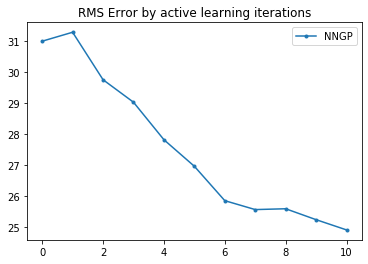

In [13]:
plt.plot(rmses, label='NNGP', marker='.')
plt.title('RMS Error by active learning iterations')
plt.legend()

In [16]:
# Show some predictions
print(model.predict(sess, data = X_test[:3]))
print(y_test[:3])

[[269.82272]
 [236.60335]
 [228.05836]]
[[269.35414184]
 [199.67728249]
 [197.7762695 ]]


In [27]:
# show some uncertainties
estimator.estimate(sess, X_pool)[:3]

array([160.86413073, 235.44600944, 191.88563576])